# Homework 07: Linear Discriminant Analysis
## Kerem Girenes
### May 13, 2022

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import pandas as pd
import scipy.spatial.distance as spadt

## Importing Data

In [3]:
images = np.genfromtxt("hw07_data_set_images.csv", delimiter=",")
labels = np.genfromtxt("hw07_data_set_labels.csv", delimiter=",")

## Dividing the Data Set

In [4]:
X_train = images[:2000]
X_test = images[2000:]
y_train = labels[:2000].astype(int)
y_test = labels[2000:].astype(int)

# ten distinct classes
K = 10

# N_train = N_test
N = X_train.shape[0]

# Pixel Count
PX = X_train.shape[1]

print(K, N, PX)

10 2000 784


## TRAIN: Class Means and Overall Mean

In [5]:
class_means = np.zeros((K,PX))
for k in range(K):
    for px in range(PX):
        px_sum = 0
        px_tot = 0
        for n in range(N):
            if k+1 == y_train[n]:
                px_sum += X_train[n, px]
                px_tot += 1
        class_means[k, px] = px_sum/px_tot

print(class_means.shape)

overall_mean = np.zeros(PX)
for px in range(PX):
    px_sum = 0
    for k in range(K):
        px_sum += class_means[k, px]
    overall_mean[px] = px_sum / K

print(overall_mean.shape)

(10, 784)
(784,)


## TEST: Class Means and Overall Mean

In [6]:
class_means_test = np.zeros((K,PX))
for k in range(K):
    for px in range(PX):
        px_sum = 0
        px_tot = 0
        for n in range(N):
            if k+1 == y_test[n]:
                px_sum += X_test[n, px]
                px_tot += 1
        class_means_test[k, px] = px_sum/px_tot

print(class_means_test.shape)

overall_mean_test = np.zeros(PX)
for px in range(PX):
    px_sum = 0
    for k in range(K):
        px_sum += class_means_test[k, px]
    overall_mean_test[px] = px_sum / K

print(overall_mean_test.shape)

(10, 784)
(784,)


## Calculate SW and SB Matrices

In [7]:
SW = np.zeros((PX,PX))

for n in range(N):
    for k in range(K):
        if k+1 == y_train[n]:
            SW += np.outer((X_train[n] - class_means[k]), X_train[n] - class_means[k])


SB = np.zeros((PX,PX))

for n in range(N):
    for k in range(K):
        if k+1 == y_train[n]:
            SB += np.outer((class_means[k] - overall_mean), class_means[k] - overall_mean)


print(SW[0:4, 0:4])
print(SB[0:4, 0:4])

[[  195.0531401    138.98550725   138.24154589   273.64251208]
 [  138.98550725   146.68407152   137.97108222   212.80522823]
 [  138.24154589   137.97108222   237.79940915   222.04558827]
 [  273.64251208   212.80522823   222.04558827 10381.73114607]]
[[ 0.84897197  0.86072123  1.26219781  4.64558159]
 [ 0.86072123  1.07439428  2.24943399  8.50607889]
 [ 1.26219781  2.24943399  6.68502625 25.27744199]
 [ 4.64558159  8.50607889 25.27744199 97.34175554]]


## Calculate the Eigenvalues and Eigenvectors

In [8]:
values, vectors = linalg.eig(np.dot(np.linalg.inv(SW), SB))
values = np.real(values)
vectors = np.real(vectors)

print(values[0:9])

[26.0779499  11.57921889  7.8737341   5.12190228  3.60070803  3.2272137
  2.71339055  1.36887669  1.13350354]


## Calculate and Plot the Two-Dimensional Projections

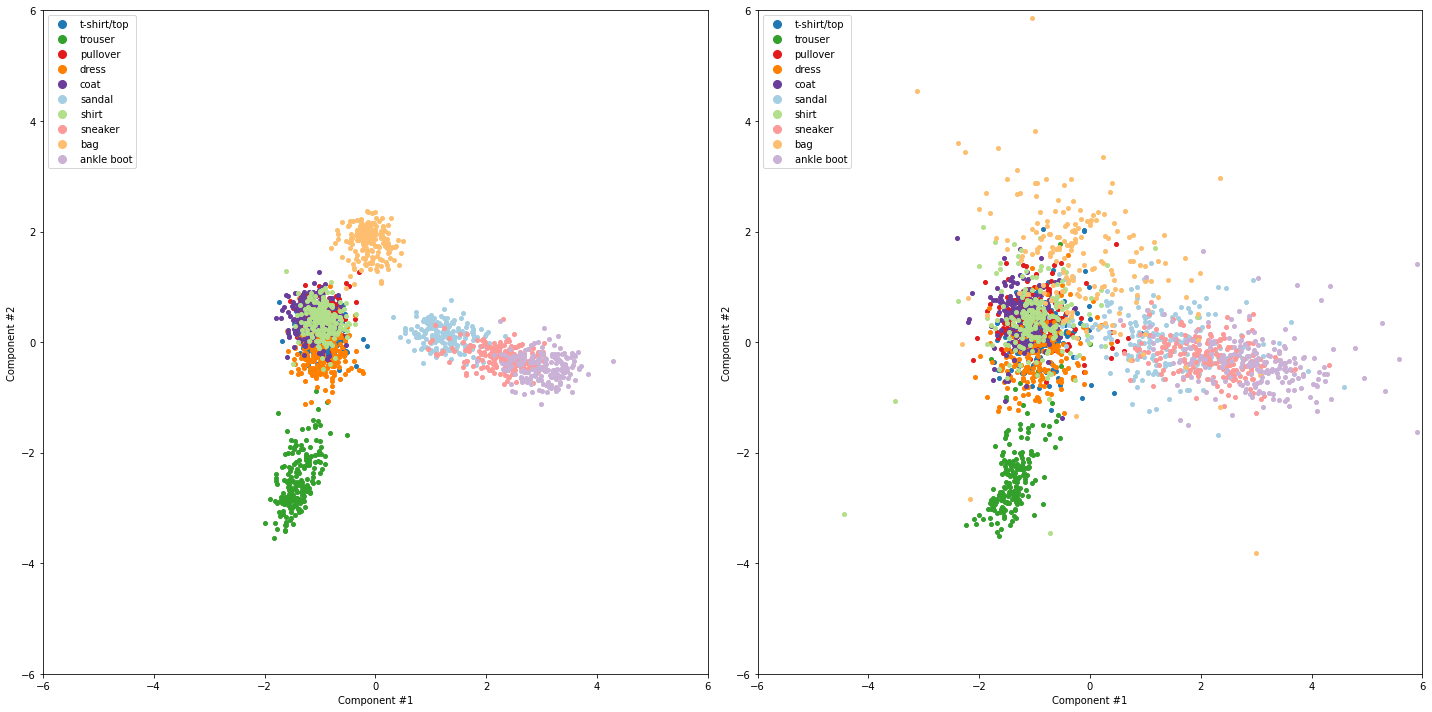

In [9]:
def z_func(vectors, W_size, X, overall_mean):
    return np.matmul(X - overall_mean, vectors[:,0:W_size])

Z_train = z_func(vectors, 2, X_train, overall_mean)
Z_test = z_func(vectors, 2, X_test, overall_mean_test)

point_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6"])
plot_legend = np.array(["t-shirt/top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"])

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
for k in range(K):
    plt.plot(Z_train[y_train == k + 1, 0], Z_train[y_train == k + 1, 1], marker = "o", markersize = 4, linestyle = "none", color = point_colors[k])
plt.legend(plot_legend, loc = "upper left", markerscale = 2)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("Component #1")
plt.ylabel("Component #2")

plt.subplot(1, 2, 2)
for k in range(K):
    plt.plot(Z_test[y_test == k + 1, 0], Z_test[y_test == k + 1, 1], marker = "o", markersize = 4, linestyle = "none", color = point_colors[k])
plt.legend(plot_legend, loc = "upper left", markerscale = 2)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("Component #1")
plt.ylabel("Component #2")

plt.tight_layout()

## Calculate Confusion Matrices

In [10]:
Z_train = z_func(vectors, 9, X_train, overall_mean)
Z_test = z_func(vectors, 9, X_test, overall_mean_test)

## Training Set
y_hat_train = np.zeros(N)
for point in range(N):
    distances = []
    for neigh in range(N):
        distances.append(spadt.euclidean(Z_train[point], Z_train[neigh]))
    indices = sorted(range(len(distances)), key = lambda sub: distances[sub])[:11]
    y_hat_train[point] = np.bincount(y_train[indices]).argmax()

confusion_matrix_train = pd.crosstab(y_hat_train, y_train, rownames = ['y_hat'], colnames = ['y_train'])
print(confusion_matrix_train)

## Test Set
y_hat_test = np.zeros(N)
for point in range(N):
    distances = []
    for neigh in range(N):
        distances.append(spadt.euclidean(Z_test[point], Z_test[neigh]))
    indices = sorted(range(len(distances)), key = lambda sub: distances[sub])[:11]
    y_hat_test[point] = np.bincount(y_test[indices]).argmax()

confusion_matrix_test = pd.crosstab(y_hat_test, y_test, rownames = ['y_hat'], colnames = ['y_test'])
print(confusion_matrix_test)

y_train   1    2    3    4    5    6    7    8    9    10
y_hat                                                    
1.0      203    0    1    1    0    0   15    0    0    0
2.0        0  192    0    1    0    0    0    0    0    0
3.0        0    0  198    0    3    0   11    0    0    0
4.0        2    2    1  202    3    0    4    0    0    0
5.0        0    0    8    1  201    0    9    0    0    0
6.0        0    0    0    0    0  175    0    3    0    0
7.0        9    0    2    6   11    0  168    0    1    0
8.0        0    0    0    0    0    3    0  196    0    1
9.0        0    0    0    0    0    0    0    0  183    0
10.0       0    0    0    0    0    0    0    0    0  184
y_test   1    2    3    4    5    6   7    8    9    10
y_hat                                                  
1.0     154    0   16    7    2    2  40    0    5    0
2.0       0  182    1    2    1    0   0    0    0    0
3.0       8    3  138    2   26    0  24    0    0    0
4.0      12    3    4  1